In [70]:
import pandas as pd
import sklearn.tree as sktree
import scipy as sp
import os
path="C:/Users/SAMSUNG/Desktop/decisiontree"
filename=os.listdir(path)

## 변수설정

### Target(Y)

target = 침수여부

In [71]:
target=pd.read_csv(path+"/침수지역2022.csv")

위의 데이터는 침수지역의 빈도(frequency)이므로 바꿔야함

In [72]:
print('한번이라도 침수가 일어난 지역수(행정동) :',target["ADM_NM"].nunique())

한번이라도 침수가 일어난 지역수(행정동) : 277


In [73]:
target["ADM_NM"]

0         우이동
1         우이동
2         우이동
3        영등포동
4         송중동
        ...  
8882      청파동
8883      한남동
8884    원효로2동
8885      동선동
8886    북가좌2동
Name: ADM_NM, Length: 8887, dtype: object

In [74]:
target["ADM_CD"]

0       1130510400
1       1130510400
2       1130510400
3       1156010400
4       1130510100
           ...    
8882    1117013100
8883    1117010800
8884    1117011300
8885    1129010300
8886    1141011900
Name: ADM_CD, Length: 8887, dtype: int64

In [75]:
target["ADM_CD_2"]

0       1109074
1       1109074
2       1109074
3       1119074
4       1109071
         ...   
8882    1103071
8883    1103074
8884    1103057
8885    1108083
8886    1113072
Name: ADM_CD_2, Length: 8887, dtype: int64

### Feature(X)

In [76]:
filename

['2. 가공데이터',
 '경사도.xlsx',
 '도로현황(도로율)_20231015181102.csv',
 '반출_행정동_소득가구_수정.xlsx',
 '반출_행정동_소득가구_수정2차.xlsx',
 '배수등급양호비율.csv',
 '서울시_강우량_정보_2022년',
 '서울시_행정동별_인구밀도_2023.csv',
 '여성.csv',
 '장애인.csv',
 '재해위험지구_경계도.csv',
 '제방.csv',
 '제방암거수문_있다없다.csv',
 '제방암거수문개수.csv',
 '침수지역2022.csv',
 '침수흔적도2022.csv',
 '토양도',
 '하천까지의_거리.csv',
 '행정동_공시지가_2020.xlsx',
 '행정동_법정동.ipynb']

In [77]:
경사도=pd.read_excel(path+"/경사도.xlsx")
행정공시지가=pd.read_excel(path+"/"+'행정동_공시지가_2020.xlsx')
도로율=pd.read_csv(path+"/"+"도로현황(도로율)_20231015181102.csv")
배수등급양호비율=pd.read_csv(path+"/"+"배수등급양호비율.csv")
하천까지의거리=pd.read_csv(path+"/"+'하천까지의_거리.csv')
제방암거수문=pd.read_csv(path+"/"+'제방암거수문_있다없다.csv')
인구밀도=pd.read_csv(path+"/"+'서울시_행정동별_인구밀도_2023.csv')
행정동소득분위=pd.read_excel(path+"/"+"반출_행정동_소득가구_수정2차.xlsx")

사회인프라

In [78]:
path2=path+"/"+'2. 가공데이터'

In [79]:
장애인=pd.read_csv(path2+"/"+"장애인.csv")
노인=pd.read_csv(path2+"/"+'노인.csv')
기초수급자=pd.read_csv(path2+"/"+"기초수급자.csv")
기초수급자_65세이상=pd.read_csv(path2+"/"+'기초생활수급자+65세이상.csv')

강우량

In [80]:
path3=path+"/"+'서울시_강우량_정보_2022년'

In [81]:
rain_dict={}
for i in range(1,10):
    rain_dict[i]=pd.read_csv(path3+"/"+f'서울시_강우량_정보_2022년0{i}월.csv',encoding='euc-kr')
for j in range(10,13):
    rain_dict[j]=pd.read_csv(path3+"/"+f'서울시_강우량_정보_2022년{j}월.csv',encoding='euc-kr')

In [82]:
rain_data=pd.concat([rain_dict[i][rain_dict[i]["10분우량"]!=0] for i in range(1,13)])

In [83]:
rain_data["month"]=rain_data["자료수집 시각"].apply(lambda x:x.split("-")[1])
rain_data["month"]=rain_data["month"].astype("int")

In [84]:
# 6월에서 9월만 추출
idx1=rain_data["month"]>=6
idx2=rain_data["month"]<=9
rain_data=rain_data[idx1&idx2]
rain_data.drop(["month"],inplace=True,axis=1)

In [85]:
rain_agg=rain_data.groupby(["구청명"])["10분우량"].agg(["sum","count"])
rain_agg.rename(columns=dict(zip(["sum","count"],["누적강수량","10분당 측정(횟수)"])),inplace=True)
rain_agg.index.rename(None,inplace=True)

In [86]:
rain_agg["추정시우량(연간)"]=rain_agg["누적강수량"]/(rain_agg["10분당 측정(횟수)"]/6)

In [87]:
rain_agg.index.rename("시군구",inplace=True)
rain_agg.reset_index(inplace=True)

In [88]:
구면적=pd.DataFrame(인구밀도.groupby(["구"])["면적 (k㎡)"].sum()).reset_index()
구면적.rename(columns={"구":"시군구"},inplace=True)

In [89]:
rain_agg=pd.merge(rain_agg,구면적)
rain_agg["추정면적당시우량(연간)"]=rain_agg["추정시우량(연간)"]/rain_agg["면적 (k㎡)"]

In [90]:
rain_agg

,시군구,누적강수량,10분당 측정(횟수),추정시우량(연간),면적 (k㎡),추정면적당시우량(연간)
0,강남구,5190.5,2927,10.639904,39.51,0.269296
1,강동구,3226.0,2005,9.653865,24.59,0.392593
2,강북구,1401.5,983,8.554425,23.60,0.362476
3,강서구,2435.5,1801,8.113826,41.44,0.195797
4,관악구,3227.0,1878,10.309904,29.57,0.348661
5,광진구,1587.5,1013,9.402764,17.06,0.551159
6,구로구,3056.5,1781,10.297024,20.12,0.511781
7,금천구,3068.0,1843,9.988063,13.02,0.767132
8,노원구,2922.0,1989,8.814480,35.44,0.248716
9,도봉구,1534.5,995,9.253266,20.65,0.448100


하수관거시설
- 맨홀오수토실토구
- 열린데이터광장 '서울시 하수관거 통계'

|용어|설명|
|--|--|
|하수관거|여러 하수구에서 하수를 모아 하수처리장으로 내려보내는 큰 하수도관|
|시설연장|차집관거 시설연장을 포함한 합류식으로 설치된 시설연장(암거+개거+측구)|
|측구|우수를 배수하기 위하여 도로, 철도선로 등에 연접하여 설치한 배수시설|
|맨홀|하수관거의 청소, 환기, 점검 및 조사 등을 위한 시설로서 일반적으로 하수관거가 합류하는 장소, 경사, 방향 및 관경이 변하는 장소 및 일정간격마다 설치된 것|
|우?오수받이|정하수 또는 공장폐수 등의 오수를 관거로 유입시키기 전에 설치하는 물받이 및 도로측구 또는 가옥으로부터 유입하는 우수를 모아서 하수관거에 유입시키기 전에 설치하는 물받이|
|우수토실| 합류식하수도에서 우천시 일정량의 하수를 막아 하수처리장에 수송하고 나머지 하수는 하천 등의 수역으로 방류하기 위한 위어 등의 시설|
|우수토구|하수도시설에서 처리수나 우수를 공공수역에 방류하는 방류구(우수토실 제외)|

In [91]:
하수관거=pd.read_excel(r"C:\Users\SAMSUNG\Desktop\추가데이터\하수관거(맨홀,측구,우수관거등).xlsx")

In [92]:
맨홀측구관거=pd.DataFrame(data=하수관거.loc[1:])
맨홀측구관거.rename(columns=dict(zip(맨홀측구관거.columns,하수관거.loc[0])),inplace=True)
맨홀측구관거.drop([0,'오수받이 (개소)'],axis=1,inplace=True)
맨홀측구관거.rename(columns={'자치구별(2)':"GU_NAME","맨홀 (개소)":"맨홀수",'토실·토구 (개소)':"토실토구수"},inplace=True)
맨홀측구관거[['맨홀수', '토실토구수', '측구(m)', '우수관거(m)']]=맨홀측구관거[['맨홀수', '토실토구수', '측구(m)', '우수관거(m)']].astype("float")
맨홀측구관거=pd.merge(맨홀측구관거,rain_agg[["시군구",'면적 (k㎡)']],left_on="GU_NAME",right_on="시군구")

In [93]:
맨홀측구관거

,GU_NAME,맨홀수,토실토구수,측구(m),우수관거(m),시군구,면적 (k㎡)
0,종로구,9899.0,165.0,11993.0,476.0,종로구,23.91
1,중구,8242.0,45.0,1259.0,1186.0,중구,9.96
2,용산구,9880.0,124.0,5307.0,99.0,용산구,21.86
3,성동구,8620.0,130.0,1636.0,3555.0,성동구,16.86
4,광진구,10303.0,51.0,238.0,3439.0,광진구,17.06
5,동대문구,12242.0,109.0,378.0,1513.0,동대문구,14.21
6,중랑구,12406.0,71.0,368.0,9411.0,중랑구,18.50
7,성북구,15170.0,344.0,5741.0,3732.0,성북구,24.57
8,강북구,11163.0,155.0,522.0,215.0,강북구,23.60
9,도봉구,9515.0,392.0,1083.0,3532.0,도봉구,20.65


In [94]:
for col in ["측구(m)","우수관거(m)"]:
    맨홀측구관거[col.replace("m","km")]=맨홀측구관거[col].apply(lambda x:x/1000000)

In [95]:
맨홀측구관거.drop(["시군구","측구(m)",'우수관거(m)'],axis=1,inplace=True)

In [96]:
#이떄 너비는 모두 1m로 가정
for col in ["맨홀수","토실토구수","측구(km)","우수관거(km)"]:
    if "(km)" not in col:
        맨홀측구관거[f"면적당{col}"]=맨홀측구관거[col]/맨홀측구관거["면적 (k㎡)"]
    else:
        맨홀측구관거[f"면적당{col.replace("km","%")}"]=맨홀측구관거[col]/맨홀측구관거["면적 (k㎡)"]*100

In [97]:
맨홀측구관거

,GU_NAME,맨홀수,토실토구수,면적 (k㎡),측구(km),우수관거(km),면적당맨홀수,면적당토실토구수,면적당측구(%),면적당우수관거(%)
0,종로구,9899.0,165.0,23.91,0.011993,0.000476,414.010874,6.900878,0.050159,0.001991
1,중구,8242.0,45.0,9.96,0.001259,0.001186,827.510040,4.518072,0.012641,0.011908
2,용산구,9880.0,124.0,21.86,0.005307,0.000099,451.967063,5.672461,0.024277,0.000453
3,성동구,8620.0,130.0,16.86,0.001636,0.003555,511.269276,7.710558,0.009703,0.021085
4,광진구,10303.0,51.0,17.06,0.000238,0.003439,603.927315,2.989449,0.001395,0.020158
5,동대문구,12242.0,109.0,14.21,0.000378,0.001513,861.505982,7.670654,0.002660,0.010647
6,중랑구,12406.0,71.0,18.50,0.000368,0.009411,670.594595,3.837838,0.001989,0.050870
7,성북구,15170.0,344.0,24.57,0.005741,0.003732,617.419617,14.000814,0.023366,0.015189
8,강북구,11163.0,155.0,23.60,0.000522,0.000215,473.008475,6.567797,0.002212,0.000911
9,도봉구,9515.0,392.0,20.65,0.001083,0.003532,460.774818,18.983051,0.005245,0.017104


빗물펌프장

In [98]:
빗물펌프장_거리=pd.read_excel(r"C:\Users\SAMSUNG\Desktop\추가데이터\거리계산.xlsx")
빗물펌프장_거리.rename(columns=dict(zip(빗물펌프장_거리.columns,["ADM_NM","펌프장","빗물펌프장까지의거리(m)"])),inplace=True)
빗물펌프장_정보=pd.read_excel(r"C:\Users\SAMSUNG\Desktop\깃\Total_Projects\Team_Projects\005_서울시빅데이터\정훈노트\빗물펌프장_전처리.xlsx")
펌프장거리정보=pd.merge(빗물펌프장_거리,빗물펌프장_정보)
펌프장거리정보.drop(["Unnamed: 0","위치","GU_NAME"],axis=1,inplace=True)

In [99]:
# 파일 merge
펌프장거리정보

,ADM_NM,펌프장,빗물펌프장까지의거리(m),유수지용량(㎥),토출량(㎥/분),펌프(합산)
0,사직동,용산,5019.271351,121000.0,460.0,1300
1,삼청동,용산,6800.809289,121000.0,460.0,1300
2,부암동,용산,7508.836699,121000.0,460.0,1300
3,평창동,용산,9605.869470,121000.0,460.0,1300
4,무악동,용산,5303.808920,121000.0,460.0,1300
...,...,...,...,...,...,...
49411,천호2동,고덕,4502.993910,65000.0,3971.0,9650
49412,길동,고덕,3312.629950,65000.0,3971.0,9650
49413,강일동,고덕,765.345623,65000.0,3971.0,9650
49414,상일1동,고덕,1558.486131,65000.0,3971.0,9650


In [100]:
# 행정동마다 최단거리의 펌프장
빗물펌프장종합=pd.merge(pd.DataFrame(펌프장거리정보.groupby(["ADM_NM"])["빗물펌프장까지의거리(m)"].min()).reset_index()
         ,펌프장거리정보,left_on="빗물펌프장까지의거리(m)",right_on='빗물펌프장까지의거리(m)')
빗물펌프장종합.drop(["ADM_NM_y"],axis=1,inplace=True)
빗물펌프장종합.rename(columns={'ADM_NM_x':"ADM_NM"},inplace=True)
빗물펌프장종합.drop("유수지용량(㎥)",axis=1,inplace=True) #유수용량은 nan값이 너무 많아 쓸수가 없음

In [101]:
# 빗물펌프종합=pd.merge(빗물펌프장종합,인구밀도[["행정동","면적 (k㎡)"]],left_on="ADM_NM",right_on="행정동")

In [102]:
빗물펌프장종합.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ADM_NM         425 non-null    object 
 1   빗물펌프장까지의거리(m)  425 non-null    float64
 2   펌프장            425 non-null    object 
 3   토출량(㎥/분)       421 non-null    float64
 4   펌프(합산)         425 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 16.7+ KB


In [103]:
빗물펌프장종합

,ADM_NM,빗물펌프장까지의거리(m),펌프장,토출량(㎥/분),펌프(합산)
0,가락1동,1336.451802,수서,150.0,500
1,가락2동,646.717524,탄천,1992.0,5800
2,가락본동,358.128508,탄천,1992.0,5800
3,가리봉동,1007.478249,가산2,620.0,1550
4,가산동,466.990492,가산1,640.0,1590
...,...,...,...,...,...
420,효창동,1284.697842,원효,1096.0,3100
421,후암동,1819.097470,삼각지,630.0,1400
422,휘경1동,357.712372,휘경1,668.0,2280
423,휘경2동,300.317946,휘경1,668.0,2280


30년 이상 노후 건물

In [104]:
노후건물=pd.read_csv(r"C:\Users\SAMSUNG\Desktop\추가데이터\개수지롱.csv")

In [105]:
노후건물.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OBJECTID_1  424 non-null    int64  
 1   OBJECTID    424 non-null    float64
 2   BASE_YEAR   424 non-null    int64  
 3   ADM_CD      424 non-null    int64  
 4   ADM_NM      424 non-null    object 
 5   Shape_Area  424 non-null    float64
 6   GU_CODE     424 non-null    int64  
 7   GU_NAME     424 non-null    object 
 8   POP         424 non-null    int64  
 9   cluster     424 non-null    float64
 10  NUMPOINTS   424 non-null    int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 36.6+ KB


In [106]:
노후건물[["ADM_NM","NUMPOINTS"]]

,ADM_NM,NUMPOINTS
0,사직동,485
1,삼청동,344
2,부암동,972
3,평창동,1331
4,무악동,101
...,...,...
419,둔촌1동,11
420,둔촌2동,574
421,암사1동,1050
422,천호2동,1601


소득소비

In [107]:
소득소비=pd.read_csv(r"C:\Users\SAMSUNG\Desktop\추가데이터\서울시 상권분석서비스(소득소비-행정동)_20231101_서울열린데이터광장.csv",encoding='euc-kr')

In [108]:
소득소비.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7650 entries, 0 to 7649
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   기준_년분기_코드   7650 non-null   int64  
 1   행정동_코드      7650 non-null   int64  
 2   행정동_코드_명    7650 non-null   object 
 3   월_평균_소득_금액  7650 non-null   int64  
 4   지출_총금액      7650 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 299.0+ KB


In [109]:
소득소비.rename(columns={'행정동_코드_명':'ADM_NM'},inplace=True)

In [110]:
# 월평균소득,지출은 2022년 평균으로 구함
i1=소득소비["기준_년분기_코드"]==20221
i2=소득소비["기준_년분기_코드"]==20222
i3=소득소비["기준_년분기_코드"]==20223
i4=소득소비["기준_년분기_코드"]==20224
소득소비=pd.DataFrame(소득소비[i1|i2|i3|i4].groupby("ADM_NM")[["월_평균_소득_금액",'지출_총금액']].sum()).reset_index()

In [111]:
소득소비[["월_평균_소득_금액",'지출_총금액']]=소득소비[["월_평균_소득_금액",'지출_총금액']].applymap(lambda x:x/4)

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14152\215802690.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  소득소비[["월_평균_소득_금액",'지출_총금액']]=소득소비[["월_평균_소득_금액",'지출_총금액']].applymap(lambda x:x/4)


In [112]:
소득소비

,ADM_NM,월_평균_소득_금액,지출_총금액
0,가락1동,4973588.0,5.445590e+09
1,가락2동,3910198.0,6.054228e+09
2,가락본동,3521561.0,8.160591e+09
3,가리봉동,2336331.0,1.087078e+09
4,가산동,2567594.0,3.612865e+10
...,...,...,...
419,효창동,3523201.0,9.740932e+08
420,후암동,3013677.0,2.002564e+09
421,휘경1동,2722774.0,3.357385e+09
422,휘경2동,3071586.0,2.217352e+09


관공서

In [113]:
관공서=pd.read_excel(r"C:\Users\SAMSUNG\Desktop\추가데이터\인프라_행정동별_관공서합계(경찰서,병원,소방서).xlsx")

In [114]:
관공서.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   동별      426 non-null    object
 1   소계      426 non-null    int64 
 2   병원      426 non-null    int64 
 3   경찰      426 non-null    int64 
 4   소방서     426 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 16.8+ KB


In [115]:
관공서.rename(columns={"동별":"ADM_NM"},inplace=True)

In [116]:
관공서

,ADM_NM,소계,병원,경찰,소방서
0,사직동,78,75,3,0
1,삼청동,12,11,1,0
2,부암동,6,4,1,1
3,평창동,16,15,1,0
4,무악동,6,6,0,0
...,...,...,...,...,...
421,둔촌1동,1,1,0,0
422,둔촌2동,30,28,2,0
423,강일동,18,17,1,0
424,상일1동,1,0,1,0


### 데이터 병합

행정동 단위
> 경사도, 행정공시지가, 배수등급양호비율, 하천까지의 거리, 제방수문암거

In [117]:
# import PublicDataReader as pdr
# 행정동코드 = pdr.code_hdong()
# import numpy as np
# 행정동=행정동코드[행정동코드["시도명"]=="서울특별시"][["시군구명","읍면동명"]]
# 행정동.index=행정동.index.astype('int')
# 행정동["시군구명"]=행정동["시군구명"].str.strip()
# 행정동["읍면동명"]=행정동["읍면동명"].str.strip()
# 행정동=행정동[행정동["시군구명"]!=""][행정동["읍면동명"]!=""]

----------

In [118]:
per_경사도=pd.DataFrame(경사도.groupby(["ADM_NM"])["경사도"].mean())
per_경사도.reset_index(inplace=True)

In [119]:
pre_경사도=pd.merge(경사도[["GU_NAME","ADM_NM"]],per_경사도,how='left')
pre_경사도["경사도(%)"]=pre_경사도["경사도"]*100
pre_경사도.drop_duplicates(["ADM_NM"],inplace=True)

In [120]:
pre_경사도

,GU_NAME,ADM_NM,경사도,경사도(%)
0,종로구,이화동,0.078333,7.833333
1,종로구,숭인2동,0.053125,5.312500
2,종로구,혜화동,0.078333,7.833333
3,중구,광희동,0.072500,7.250000
4,중구,을지로동,0.040000,4.000000
...,...,...,...,...
3234,관악구,난곡동,0.231667,23.166667
3427,금천구,시흥2동,0.377857,37.785714
3431,관악구,난향동,0.330000,33.000000
3464,금천구,독산2동,0.142667,14.266667


In [121]:
행정공시지가[행정공시지가.columns[[0,1,-1]]].rename(columns=dict(zip(행정공시지가.columns[[0,1]],["GU_NAME","ADM_NM"])))

,GU_NAME,ADM_NM,​평균공시지가(원/㎡)
0,중구,명동1가,56614016.0
1,중구,충무로1가,54595752.0
2,중구,명동2가,49435106.0
3,중구,을지로1가,42678973.0
4,중구,을지로2가,36948338.0
...,...,...,...
463,강서구,오곡동,243750.0
464,서초구,원지동,189153.0
465,강서구,개화동,175646.0
466,강북구,우이동,169341.0


In [122]:
배수등급양호비율[["GU_NAME","ADM_NM","양호비율"]]

,GU_NAME,ADM_NM,양호비율
0,송파구,가락1동,0.654167
1,송파구,가락2동,0.842105
2,송파구,가락본동,0.680000
3,구로구,가리봉동,0.688073
4,금천구,가산동,0.610245
...,...,...,...
412,용산구,효창동,0.980769
413,용산구,후암동,1.000000
414,동대문구,휘경1동,0.405797
415,동대문구,휘경2동,0.300578


In [123]:
하천까지의거리[["GU_NAME","ADM_NM","HubDist"]]

,GU_NAME,ADM_NM,HubDist
0,종로구,사직동,961.440982
1,종로구,삼청동,481.426072
2,종로구,부암동,719.095967
3,종로구,평창동,70.039725
4,종로구,무악동,1381.962564
...,...,...,...
419,강동구,둔촌1동,1112.581499
420,강동구,둔촌2동,286.658161
421,강동구,암사1동,1421.991249
422,강동구,천호2동,713.146580


In [124]:
제방암거수문
# 암거는 모두 가지고 있음

,GU_NAME,ADM_NM,비고,count,제방,수문,암거
0,강남구,개포1동,제방,65,1,1,1
1,강남구,개포1동,암거,58,1,1,1
2,강남구,개포1동,수문,4,1,1,1
3,강남구,개포2동,암거,95,1,1,1
4,강남구,개포2동,제방,30,1,1,1
...,...,...,...,...,...,...,...
833,중랑구,중화1동,암거,12,1,0,1
834,중랑구,중화1동,제방,4,1,0,1
835,중랑구,중화2동,암거,26,1,1,1
836,중랑구,중화2동,제방,12,1,1,1


In [125]:
인구밀도[["구","행정동","인구밀도(명/km²)"]]

,구,행정동,인구밀도(명/km²)
0,종로구,사직동,7618.699187
1,종로구,삼청동,1755.704698
2,종로구,부암동,4167.400881
3,종로구,평창동,2000.338219
4,종로구,무악동,22347.222220
...,...,...,...
421,강동구,둔촌1동,80.434783
422,강동구,둔촌2동,15520.512820
423,강동구,강일동,14638.053100
424,강동구,상일1동,21667.582420


In [126]:
행정동소득분위[["읍면동","1분위소득가구비율(%)","2분위소득가구비율(%)"
         ,"3분위소득가구비율(%)","4분위소득가구비율(%)","5분위소득가구비율(%)"]]

,읍면동,1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,사직동,0.158391,0.142992,0.214959,0.180704,0.302640
1,삼청동,0.240190,0.211653,0.229489,0.184304,0.133175
2,부암동,0.177386,0.169309,0.195334,0.212384,0.245588
3,평창동,0.119703,0.139261,0.173669,0.199565,0.367983
4,무악동,0.157974,0.118292,0.160620,0.181028,0.381708
...,...,...,...,...,...,...
418,성내3동,0.180404,0.192774,0.234538,0.218861,0.173423
419,둔촌2동,0.137338,0.148917,0.193626,0.235011,0.285108
420,암사1동,0.203770,0.215738,0.236557,0.199754,0.144180
421,천호2동,0.233815,0.231585,0.235276,0.192373,0.106951


In [127]:
행정동=pd.merge(배수등급양호비율[["GU_NAME","ADM_NM","양호비율"]]
             ,제방암거수문[["GU_NAME","ADM_NM","제방","수문"]],how="left")
행정동=pd.merge(행정동,pre_경사도,how='left')
행정동.drop("경사도",axis=1,inplace=True)
행정동.rename(columns={"양호비율":"배수등급양호비율","경사도(%)":"평균경사도(%)"},inplace=True)
행정동=pd.merge(행정동,하천까지의거리[["GU_NAME","ADM_NM","HubDist"]],how="left").rename(columns={"HubDist":"하천까지의거리(중심)"})
행정동=pd.merge(행정동,인구밀도[["구","행정동","인구밀도(명/km²)"]].rename(columns={"구":"GU_NAME","행정동":"ADM_NM"}),how="left")
행정동=pd.merge(행정동,행정동소득분위[["읍면동","1분위소득가구비율(%)","2분위소득가구비율(%)"
         ,"3분위소득가구비율(%)","4분위소득가구비율(%)","5분위소득가구비율(%)"]].rename(columns=
                                                                {'읍면동':"ADM_NM"}),how='left')
# 행정동=pd.merge(행정동
#              ,행정공시지가[행정공시지가.columns[[0,1,-1]]].rename(
#                  columns=dict(zip(행정공시지가.columns[[0,1]],["GU_NAME","ADM_NM"]))),how="left")
행정동[["1분위소득가구비율(%)","2분위소득가구비율(%)"
     ,"3분위소득가구비율(%)"
     ,"4분위소득가구비율(%)"
     ,"5분위소득가구비율(%)"]]=행정동[["1분위소득가구비율(%)","2분위소득가구비율(%)"
                            ,"3분위소득가구비율(%)","4분위소득가구비율(%)","5분위소득가구비율(%)"]].applymap(lambda x:x*100)
# 빗물펌프장 정보 추가
행정동=pd.merge(행정동,빗물펌프장종합,how='left',left_on="ADM_NM",right_on="ADM_NM")
print(len(행정동))
# 30년이상 노후건물
행정동=pd.merge(행정동,노후건물[["ADM_NM","NUMPOINTS"]].rename(columns={
    "NUMPOINTS":'노후건물수'
}),left_on="ADM_NM",right_on="ADM_NM")
# 소득소비
행정동=pd.merge(행정동,소득소비[['ADM_NM','월_평균_소득_금액','지출_총금액']],left_on="ADM_NM",right_on="ADM_NM")
# 관공서
행정동=pd.merge(행정동,관공서[["ADM_NM","경찰","소방서","병원"]],left_on="ADM_NM",right_on="ADM_NM")

830


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14152\3529520547.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ,"3분위소득가구비율(%)","4분위소득가구비율(%)","5분위소득가구비율(%)"]].applymap(lambda x:x*100)


In [128]:
# 행정동 중복 제거
행정동.drop_duplicates(subset='ADM_NM',inplace=True)

In [129]:
len(행정동)

408

In [130]:
행정동["ADM_NM"].value_counts()

ADM_NM
가락1동     1
역삼1동     1
오류1동     1
오금동      1
영등포본동    1
        ..
방학2동     1
방학1동     1
방이2동     1
방이1동     1
흑석동      1
Name: count, Length: 408, dtype: int64

In [131]:
행정동.isna().sum()

GU_NAME          0
ADM_NM           0
배수등급양호비율         0
제방               2
수문               2
평균경사도(%)         1
하천까지의거리(중심)      0
인구밀도(명/km²)      0
1분위소득가구비율(%)     1
2분위소득가구비율(%)     1
3분위소득가구비율(%)     1
4분위소득가구비율(%)     1
5분위소득가구비율(%)     1
빗물펌프장까지의거리(m)    0
펌프장              0
토출량(㎥/분)         4
펌프(합산)           0
노후건물수            0
월_평균_소득_금액       0
지출_총금액           0
경찰               0
소방서              0
병원               0
dtype: int64

Nan값 삭제

In [132]:
행정동.dropna(inplace=True)

In [133]:
len(행정동)

400

In [134]:
행정동.to_excel("./행정동단위통합데이터.xlsx")

--------

자치구별

In [135]:
도로율[["자치구별(2)","2022.2"]]

,자치구별(2),2022.2
0,자치구별(2),도로율 (%)
1,소계,23.35
2,종로구,21.15
3,중구,18.86
4,용산구,23.44
5,성동구,24.26
6,광진구,29.13
7,동대문구,22.74
8,중랑구,25.60
9,성북구,23.18


In [136]:
장애인[["동별(2)","장애인_per"]]

,동별(2),장애인_per
0,종로구,0.042206
1,중구,0.047262
2,용산구,0.035601
3,성동구,0.040202
4,광진구,0.036498
5,동대문구,0.046458
6,중랑구,0.053083
7,성북구,0.040730
8,강북구,0.059247
9,도봉구,0.049010


In [137]:
노인[["동별(2)","노인_per"]]

,동별(2),노인_per
0,종로구,0.184489
1,중구,0.189918
2,용산구,0.165642
3,성동구,0.156072
4,광진구,0.146727
5,동대문구,0.180027
6,중랑구,0.179242
7,성북구,0.168760
8,강북구,0.208990
9,도봉구,0.195573


In [138]:
rain_agg[["시군구","추정시우량(연간)"]]

,시군구,추정시우량(연간)
0,강남구,10.639904
1,강동구,9.653865
2,강북구,8.554425
3,강서구,8.113826
4,관악구,10.309904
5,광진구,9.402764
6,구로구,10.297024
7,금천구,9.988063
8,노원구,8.814480
9,도봉구,9.253266


In [139]:
시군구=pd.merge(도로율[["자치구별(2)","2022.2"]].loc[2:].rename(columns=dict(zip(["자치구별(2)","2022.2"],["동별(2)","도로율"])))
             ,노인[["동별(2)","노인_per"]])
시군구=pd.merge(시군구,장애인[["동별(2)","장애인_per"]])
시군구=pd.merge(시군구,기초수급자_65세이상[["자치구별(2)","per(기초생활수급자)",'per(기초생활수급자+65세이상)']].rename(
    columns=dict(zip(["자치구별(2)","per(기초생활수급자)",'per(기초생활수급자+65세이상)']
                     ,["동별(2)","기초생활수급자_per",'기초생활수급자+65세이상_per']))
))
시군구=pd.merge(시군구,rain_agg[["시군구","추정면적당시우량(연간)"]].rename(columns={"시군구":"동별(2)"}))
시군구[[y for y in 시군구.columns if "per" in y]]=시군구[[y for y in 시군구.columns if "per" in y]].applymap(lambda x:x*100)
시군구["도로율"]=시군구["도로율"].astype("float")
시군구=pd.merge(시군구,맨홀측구관거.rename(columns={'GU_NAME':"동별(2)"}))

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14152\3444669182.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  시군구[[y for y in 시군구.columns if "per" in y]]=시군구[[y for y in 시군구.columns if "per" in y]].applymap(lambda x:x*100)


In [156]:
시군구.to_excel("./시군구종합데이터.xlsx")

In [141]:
행정동

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),...,빗물펌프장까지의거리(m),펌프장,토출량(㎥/분),펌프(합산),노후건물수,월_평균_소득_금액,지출_총금액,경찰,소방서,병원
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,6.976744,10.697674,...,1336.451802,수서,150.0,500.0,14,4973588.0,5.445590e+09,0,1,6
2,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.54167,12.245310,14.877950,...,646.717524,탄천,1992.0,5800.0,494,3910198.0,6.054228e+09,0,0,37
3,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.23894,12.462591,17.507482,...,358.128508,탄천,1992.0,5800.0,657,3521561.0,8.160591e+09,1,0,86
4,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.00000,39.355304,28.337744,...,1007.478249,가산2,620.0,1550.0,910,2336331.0,1.087078e+09,1,0,12
5,금천구,가산동,0.610245,1.0,0.0,8.772727,468.909180,10567.85714,22.982635,26.710930,...,466.990492,가산1,640.0,1590.0,788,2567594.0,3.612865e+10,1,0,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,용산구,효창동,0.980769,1.0,0.0,12.666667,3363.536779,24777.27273,14.144849,14.960898,...,1284.697842,원효,1096.0,3100.0,419,3523201.0,9.740932e+08,0,0,12
817,용산구,후암동,1.000000,1.0,0.0,39.625000,346.532474,19465.11628,21.626764,19.248454,...,1819.097470,삼각지,630.0,1400.0,1177,3013677.0,2.002564e+09,1,1,15
819,동대문구,휘경1동,0.405797,1.0,0.0,5.800000,754.989114,25936.50794,32.527147,26.176374,...,357.712372,휘경1,668.0,2280.0,1200,2722774.0,3.357385e+09,0,0,28
821,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,26.526171,22.254037,...,300.317946,휘경1,668.0,2280.0,887,3071586.0,2.217352e+09,1,1,8


In [142]:
통합=pd.merge(행정동,시군구.rename(columns={"동별(2)":"GU_NAME"}),how="left")

In [143]:
침수여부=pd.DataFrame(target["ADM_NM"].unique(),columns=["ADM_NM"])

In [144]:
침수여부=pd.DataFrame(target["ADM_NM"].unique(),columns=["ADM_NM"])
침수여부["침수여부"]=1
통합=pd.merge(통합,침수여부,how="left")
통합.isna().sum() # Nan값 확인

GU_NAME                0
ADM_NM                 0
배수등급양호비율               0
제방                     0
수문                     0
평균경사도(%)               0
하천까지의거리(중심)            0
인구밀도(명/km²)            0
1분위소득가구비율(%)           0
2분위소득가구비율(%)           0
3분위소득가구비율(%)           0
4분위소득가구비율(%)           0
5분위소득가구비율(%)           0
빗물펌프장까지의거리(m)          0
펌프장                    0
토출량(㎥/분)               0
펌프(합산)                 0
노후건물수                  0
월_평균_소득_금액             0
지출_총금액                 0
경찰                     0
소방서                    0
병원                     0
도로율                    0
노인_per                 0
장애인_per                0
기초생활수급자_per            0
기초생활수급자+65세이상_per      0
추정면적당시우량(연간)           0
맨홀수                    0
토실토구수                  0
면적 (k㎡)                0
측구(km)                 0
우수관거(km)               0
면적당맨홀수                 0
면적당토실토구수               0
면적당측구(%)               0
면적당우수관거(%)             0
침수여부                 137
dtype: int64

In [145]:
# Nan값 -> 0 으로 쳐리하면 침수여부(0값)이 침수가 일어나지 않은 데이터로 바뀜
통합=통합.fillna(0)

In [146]:
통합.dropna(axis=0,inplace=True)

In [147]:
통합.drop_duplicates("ADM_NM",inplace=True)

In [148]:
통합

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),...,맨홀수,토실토구수,면적 (k㎡),측구(km),우수관거(km),면적당맨홀수,면적당토실토구수,면적당측구(%),면적당우수관거(%),침수여부
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,6.976744,10.697674,...,14357.0,172.0,33.88,0.011036,0.097237,423.760331,5.076741,0.032574,0.287004,1.0
1,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.54167,12.245310,14.877950,...,14357.0,172.0,33.88,0.011036,0.097237,423.760331,5.076741,0.032574,0.287004,1.0
2,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.23894,12.462591,17.507482,...,14357.0,172.0,33.88,0.011036,0.097237,423.760331,5.076741,0.032574,0.287004,1.0
3,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.00000,39.355304,28.337744,...,10913.0,108.0,20.12,0.004848,0.021362,542.395626,5.367793,0.024095,0.106173,1.0
4,금천구,가산동,0.610245,1.0,0.0,8.772727,468.909180,10567.85714,22.982635,26.710930,...,6543.0,44.0,13.02,0.000000,0.009109,502.534562,3.379416,0.000000,0.069962,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,용산구,효창동,0.980769,1.0,0.0,12.666667,3363.536779,24777.27273,14.144849,14.960898,...,9880.0,124.0,21.86,0.005307,0.000099,451.967063,5.672461,0.024277,0.000453,0.0
396,용산구,후암동,1.000000,1.0,0.0,39.625000,346.532474,19465.11628,21.626764,19.248454,...,9880.0,124.0,21.86,0.005307,0.000099,451.967063,5.672461,0.024277,0.000453,0.0
397,동대문구,휘경1동,0.405797,1.0,0.0,5.800000,754.989114,25936.50794,32.527147,26.176374,...,12242.0,109.0,14.21,0.000378,0.001513,861.505982,7.670654,0.002660,0.010647,0.0
398,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,26.526171,22.254037,...,12242.0,109.0,14.21,0.000378,0.001513,861.505982,7.670654,0.002660,0.010647,0.0


In [149]:
temp=pd.DataFrame(통합["침수여부"].value_counts())
temp

,count
침수여부,
1.0,263
0.0,137


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14152\2042596608.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sb.barplot(x=temp.index,y=temp["count"],palette=["red","blue"])
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14152\2042596608.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["침수 미발생","침수 발생"])


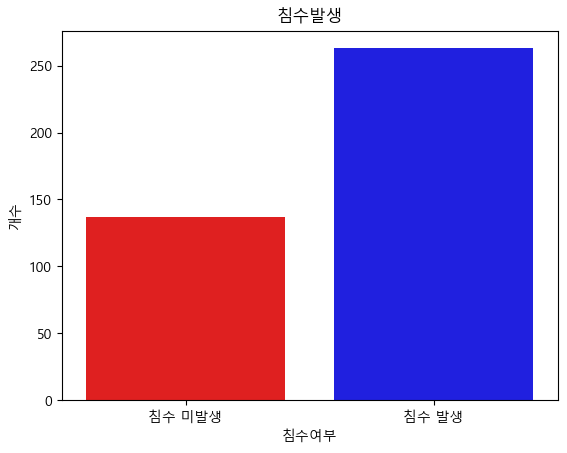

In [150]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams["font.family"]="Malgun gothic"
plt.figure()
ax=sb.barplot(x=temp.index,y=temp["count"],palette=["red","blue"])
plt.title("침수발생")
plt.ylabel("개수")
ax.set_xticklabels(["침수 미발생","침수 발생"])
plt.show()

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_14152\1624035636.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rename_col2)


Text(0.5, 1.0, '독립변수 Boxplot')

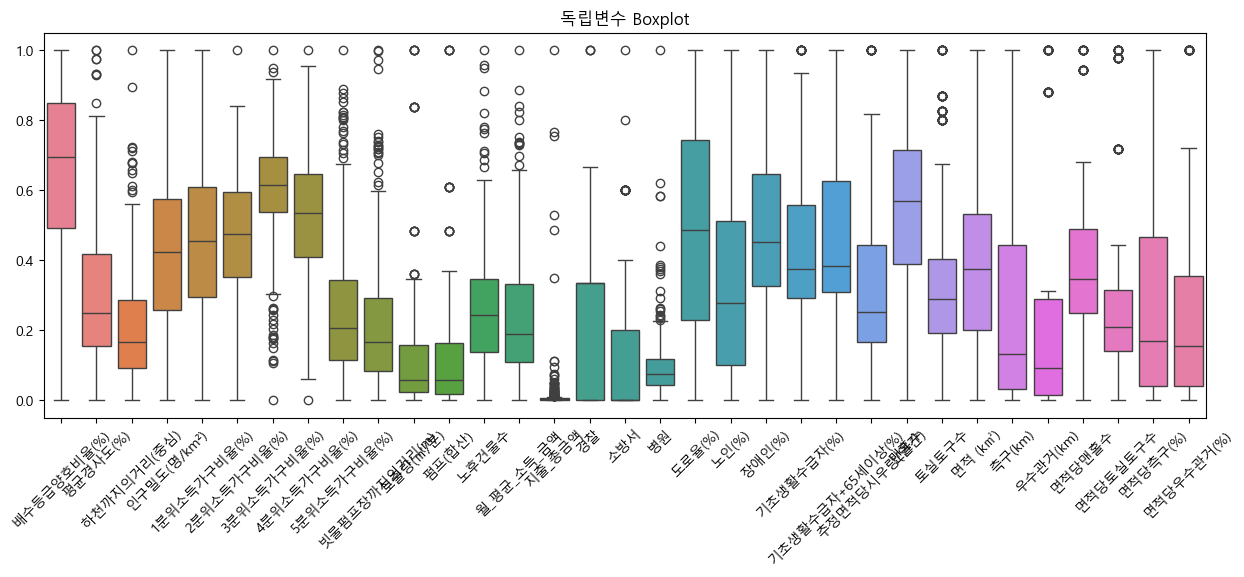

In [151]:
import sklearn.preprocessing as skpre
import pandas as pd
box_col=[x for x in 통합.columns if x not in ["GU_NAME","ADM_NM","제방","수문","침수여부","펌프장"]]
rename_col=[x.replace("_per","(%)") for x in box_col]
rename_col1=[x.replace("율(%)","율") for x in rename_col]
rename_col2=[x.replace("율","율(%)") for x in rename_col1]
plt.figure(figsize=(15,5))
ax=sb.boxplot(pd.DataFrame(skpre.minmax_scale(통합[box_col]),columns=rename_col))
plt.xticks(rotation=45)
ax.set_xticklabels(rename_col2)
plt.title("독립변수 Boxplot")

----------

## 모델생성

In [152]:
import sklearn.tree as sktree
import sklearn.preprocessing as skpre
import numpy as np
import sklearn.model_selection as skmod
import matplotlib.pyplot as plt
np.random.seed(10)
plt.rcParams['font.family']="Malgun Gothic"

In [153]:
# feature_cols=['배수등급양호비율', '제방', '수문', '암거', '평균경사도(%)',
#        '하천까지의거리(중심)', '인구밀도(명/km²)', '도로율', '노인_per', '장애인_per', '기초생활수급자_per',
#        '기초생활수급자+65세이상_per', '추정시우량(연간)']
target_cols=["침수여부"]
feature_cols=통합.columns.difference(["GU_NAME","ADM_NM"]+target_cols)
feature_cols

Index(['1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)',
       '5분위소득가구비율(%)', '경찰', '기초생활수급자+65세이상_per', '기초생활수급자_per', '노인_per',
       '노후건물수', '도로율', '맨홀수', '면적 (k㎡)', '면적당맨홀수', '면적당우수관거(%)', '면적당측구(%)',
       '면적당토실토구수', '배수등급양호비율', '병원', '빗물펌프장까지의거리(m)', '소방서', '수문', '우수관거(km)',
       '월_평균_소득_금액', '인구밀도(명/km²)', '장애인_per', '제방', '지출_총금액', '추정면적당시우량(연간)',
       '측구(km)', '토실토구수', '토출량(㎥/분)', '펌프(합산)', '펌프장', '평균경사도(%)',
       '하천까지의거리(중심)'],
      dtype='object')

In [154]:
train,test=skmod.train_test_split(통합,train_size=0.7,random_state=10)

In [155]:
params_model=sktree.DecisionTreeClassifier(criterion="entropy",random_state=10)
params_model.fit(X=train[feature_cols],y=train[target_cols])

ValueError: could not convert string to float: '흑석'

In [ ]:
params_model.score(X=test[feature_cols],y=test[target_cols])

0.7540983606557377

In [ ]:
print("max_depth :",params_model.get_depth())
print("max_sample_size :",params_model.get_n_leaves())

max_depth : 10
max_sample_size : 45


In [ ]:
plt.figure()
sktree.plot_tree(params_model,filled=True)
plt.savefig("tree.png",dpi=1000,bbox_inches='tight')
plt.close()

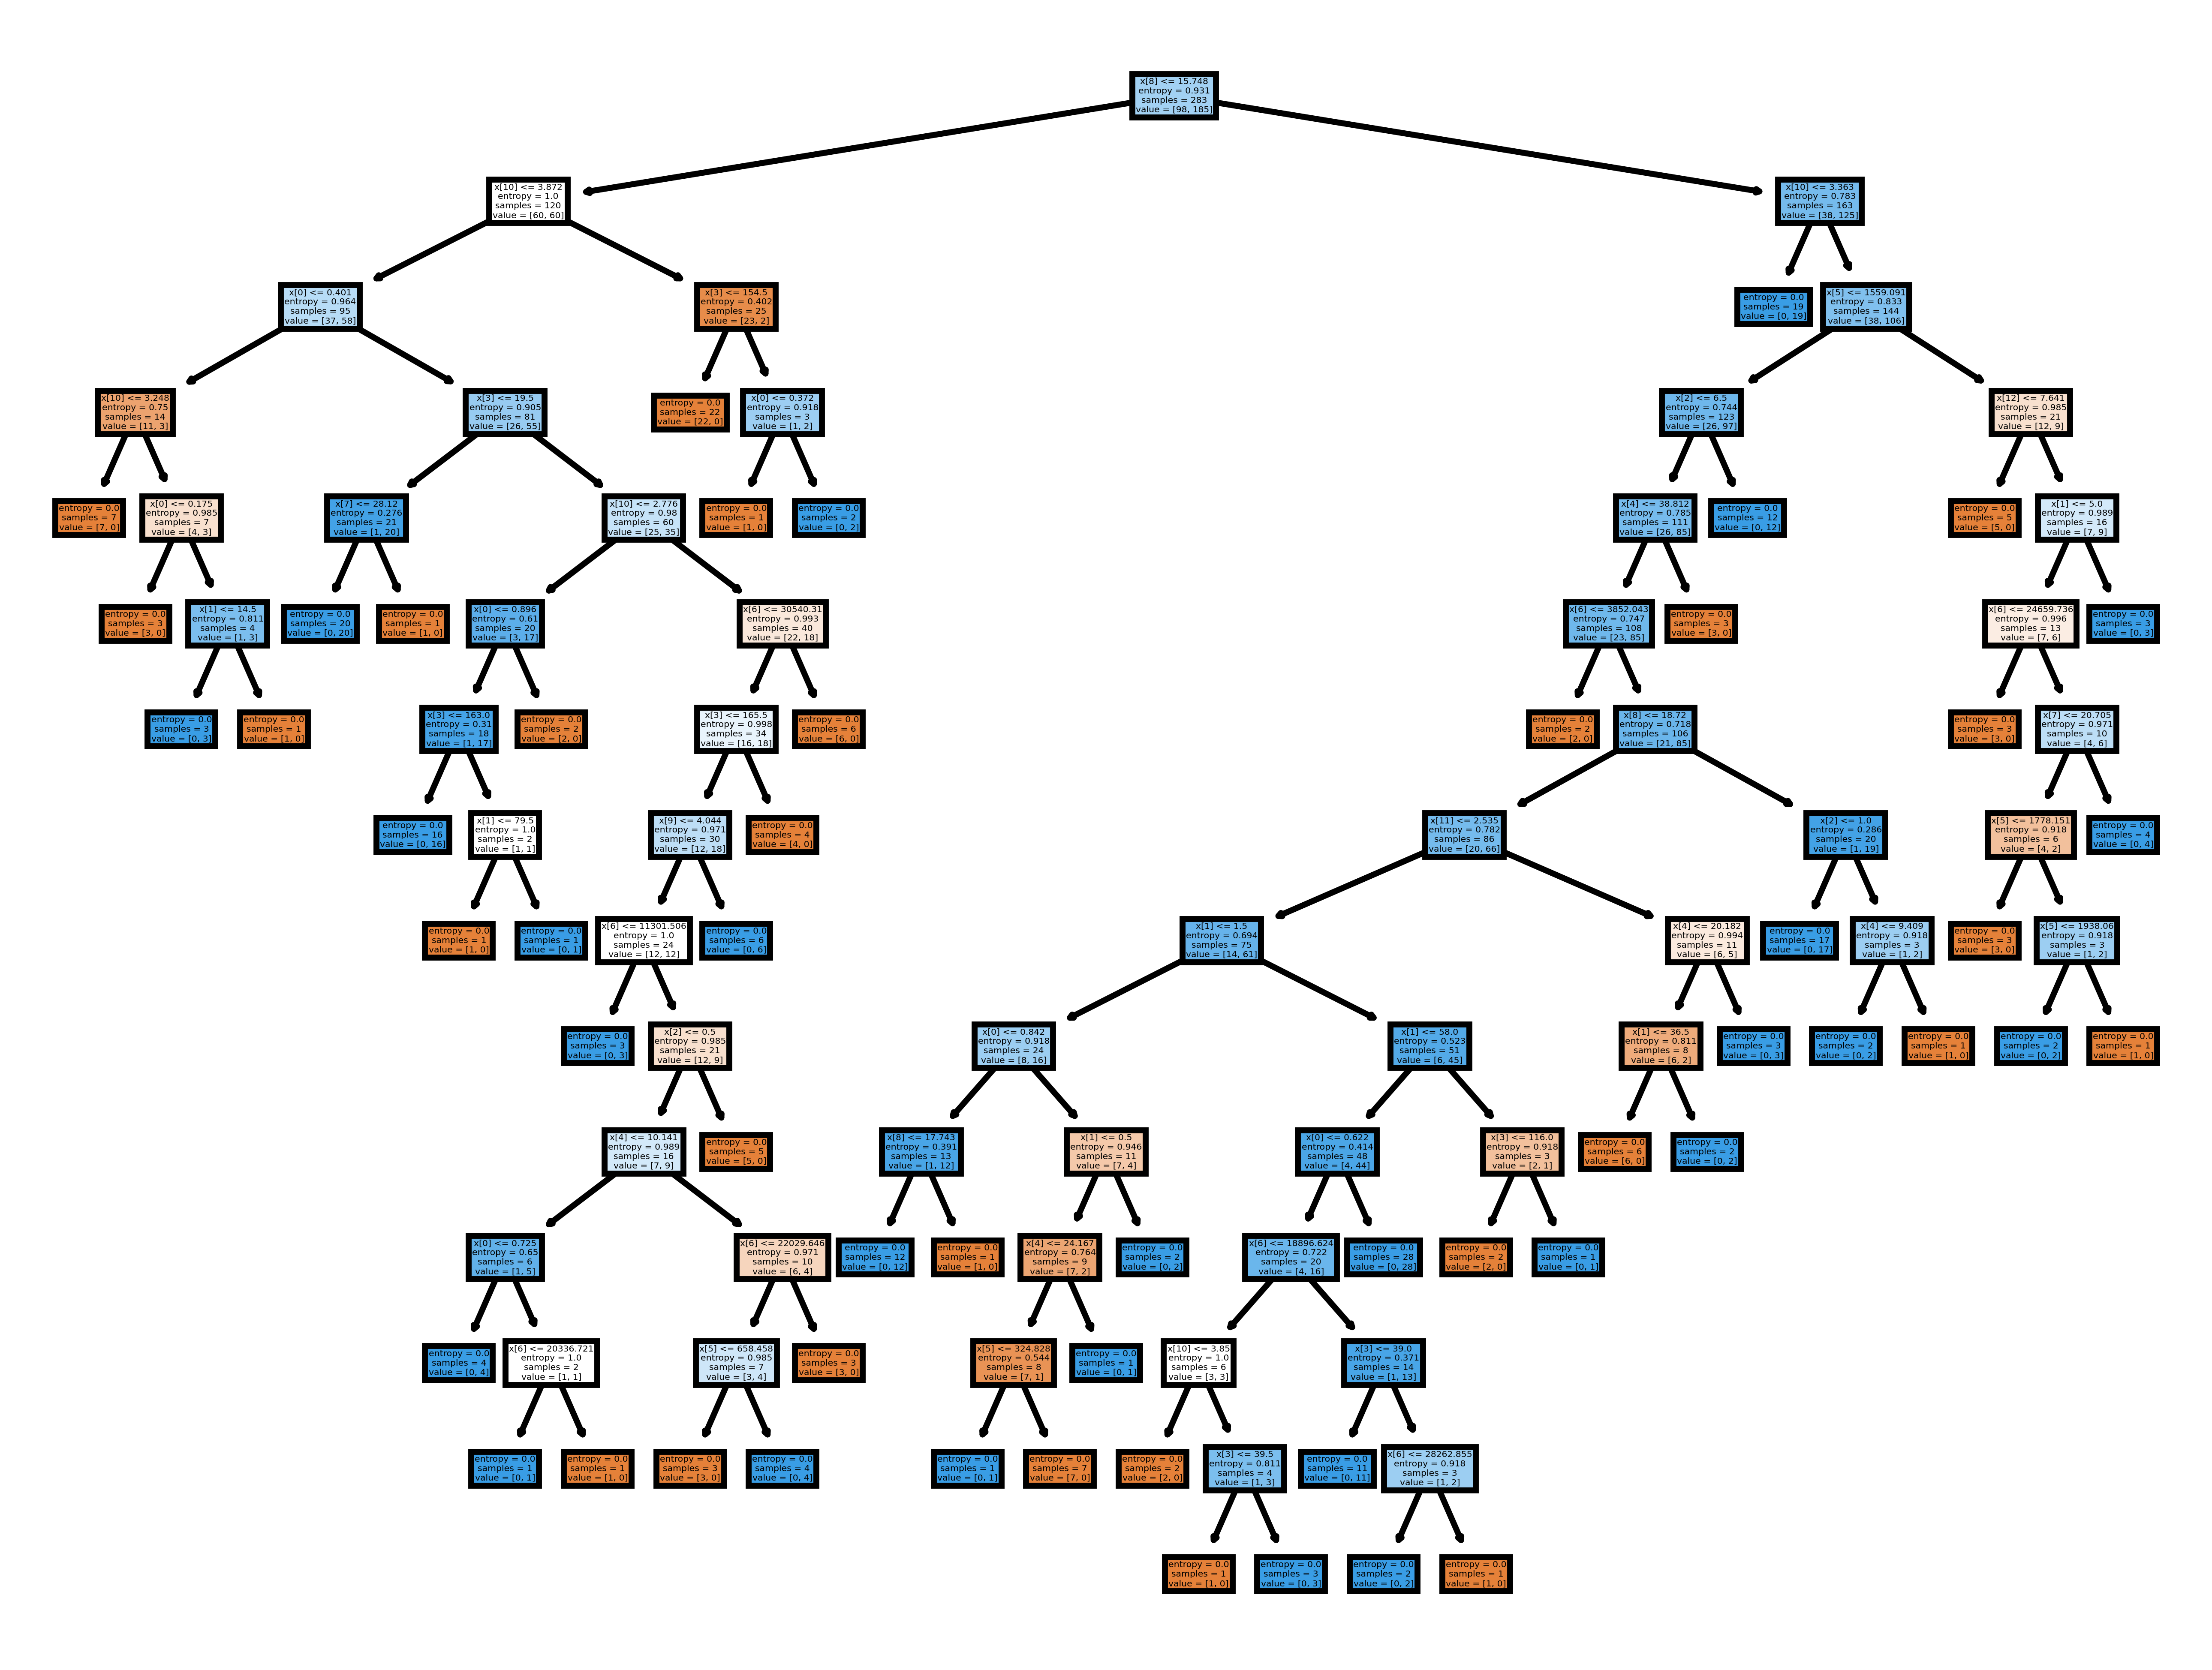

In [ ]:
# 위와 같은 과정을 진행할것.
params_model=sktree.DecisionTreeClassifier(criterion="entropy")
params_model.fit(X=통합[feature_cols],y=통합[target_cols])
max_depth,max_sample_size=params_model.get_depth(),params_model.get_n_leaves()
print("max_depth :",params_model.get_depth())
print("max_sample_size :",params_model.get_n_leaves())

max_depth : 15
max_sample_size : 63


### 파라미터 최적화

random_search 로 탐색해보겠음..
- 학습 500번
- cv=10

test 사이즈와 똑같이 나누기

-------

In [ ]:
import scipy as sp

In [ ]:
params={"max_depth":sp.stats.randint(low=2,high=max_depth)} #,"min_samples_split":sp.stats.randint(low=2,high=max_sample_size)} minsample 제거
grid_tree=sktree.DecisionTreeClassifier(criterion="entropy",random_state=10)
Random_model=skmod.RandomizedSearchCV(grid_tree,param_distributions=params,cv=10,random_state=10,n_iter=500,n_jobs=-1
                                      ,scoring="accuracy")
Random_model.fit(X=통합[feature_cols],y=통합[target_cols])

RandomizedSearchCV(cv=10,
                   estimator=DecisionTreeClassifier(criterion='entropy',
                                                    random_state=10),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000020B1D078A40>},
                   random_state=10, scoring='accuracy')

In [ ]:
통합_best_params=Random_model.best_params_
print('결과 :',Random_model.best_params_)

결과 : {'max_depth': 2}


위의 과정를 토대로 의사결정나무를 만들것

### 부트스트랩
40개의 데이터 셋 구현 -> 침수여부의 층화추출이 이루어져야 됨            
36.8%의 데이터(약 1/3)가 검증 데이터로 변환됨.          
위의 파라미터는 train_size가 다르므로 cv값을 고려했어야했음

In [ ]:
for i in range(40):
    eval(f'np.random.seed({i+1})')

In [ ]:
import sklearn.utils as skuti
acc_list=[]
best_params=[]
# tree_model=sktree.DecisionTreeClassifier(criterion="entropy",max_depth=sub_best_params["max_depth"]
#                                          ,min_samples_split=sub_best_params["min_samples_split"],
#                                    random_state=10)
for i in range(11,11+40):
    resample_data=skuti.resample(통합,replace=True,random_state=i,stratify=통합[target_cols]) #학습데이터
    resample_data.drop_duplicates("ADM_NM",inplace=True)
    test_data=통합.loc[list(set(통합.index)-set(resample_data.index))] #검증데이터

    #random search
    #params={"max_depth":sp.stats.randint(low=2,high=max_depth),"min_samples_split":sp.stats.randint(low=2,high=max_sample_size)} #수정 ->minsample drop
    params={"max_depth":sp.stats.randint(low=2,high=max_depth)}
    grid_tree=sktree.DecisionTreeClassifier(criterion="entropy",random_state=10)
    sub_Random_model=skmod.RandomizedSearchCV(estimator=grid_tree,
                                            param_distributions=params,
                                            scoring="accuracy",
                                            random_state=10,
                                            cv=10, n_iter=300,n_jobs=-1)
    sub_Random_model.fit(X=resample_data[feature_cols],y=resample_data[target_cols])
    tree_model=sub_Random_model.best_estimator_
    # tree_model.fit(X=resample_data[feature_cols],y=resample_data[target_cols]) #학습
    acc_list.append(tree_model.score(X=test_data[feature_cols],y=test_data[target_cols]))
    best_params.append(sub_Random_model.best_params_)

KeyboardInterrupt: 

In [ ]:
나무결과=pd.DataFrame(acc_list).rename(columns={0:'accuracy'})
나무결과["테스트_오차율"]=1-나무결과["accuracy"]
나무결과.sort_values(by="테스트_오차율",inplace=True)

In [ ]:
best_params

[{'max_depth': 4},
 {'max_depth': 5},
 {'max_depth': 7},
 {'max_depth': 3},
 {'max_depth': 9},
 {'max_depth': 6},
 {'max_depth': 5},
 {'max_depth': 3},
 {'max_depth': 4},
 {'max_depth': 4},
 {'max_depth': 6},
 {'max_depth': 6},
 {'max_depth': 4},
 {'max_depth': 7},
 {'max_depth': 9},
 {'max_depth': 5},
 {'max_depth': 6},
 {'max_depth': 5},
 {'max_depth': 4},
 {'max_depth': 2},
 {'max_depth': 10},
 {'max_depth': 6},
 {'max_depth': 4},
 {'max_depth': 3},
 {'max_depth': 5},
 {'max_depth': 5},
 {'max_depth': 5},
 {'max_depth': 5},
 {'max_depth': 5},
 {'max_depth': 4},
 {'max_depth': 5},
 {'max_depth': 3},
 {'max_depth': 3},
 {'max_depth': 4},
 {'max_depth': 3},
 {'max_depth': 2},
 {'max_depth': 12},
 {'max_depth': 9},
 {'max_depth': 2},
 {'max_depth': 6}]

In [ ]:
나무결과

,accuracy,테스트_오차율
8,0.791367,0.208633
34,0.770833,0.229167
9,0.755102,0.244898
17,0.753333,0.246667
35,0.742857,0.257143
30,0.737226,0.262774
31,0.727848,0.272152
38,0.725926,0.274074
7,0.722222,0.277778
27,0.714286,0.285714


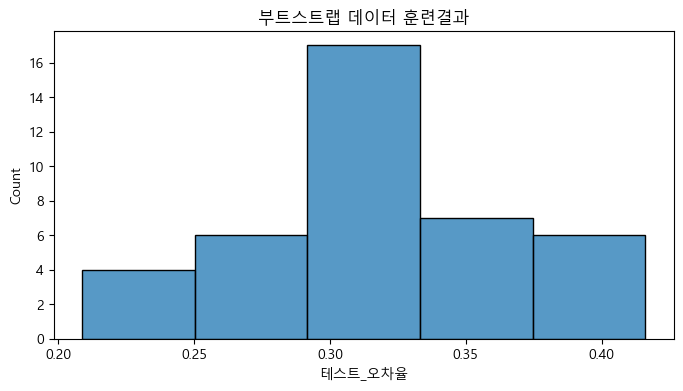

In [ ]:
import seaborn as sb
plt.figure(figsize=(8,4))
plt.title("부트스트랩 데이터 훈련결과")
sb.histplot(x=나무결과["테스트_오차율"],bins=5)
plt.show()
plt.ylabel("모델 수")
plt.close()

#### 가설검정
일반화 오차율

In [ ]:
나무결과["테스트_오차율"].mean()

0.3163208963618322

In [ ]:
#나무결과[["테스트_오차율"]]

In [ ]:
sp.stats.ttest_1samp(나무결과["테스트_오차율"],0.31)

TtestResult(statistic=0.8381366264567778, pvalue=0.4070614960256309, df=39)

일반화 오차율은 34%로 예상됨.           
즉, 일반화 accuracy는 66%

## 결과해석

In [ ]:
final_tree_model=sktree.DecisionTreeClassifier(max_depth=Random_model.best_params_["max_depth"]
                                               #,min_samples_split=Random_model.best_params_["min_samples_split"]
                                               ,random_state=10
                                               ,criterion="entropy")
final_tree_model.fit(X=통합[feature_cols],y=통합[target_cols])

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=10)

In [ ]:
info_result=pd.DataFrame(list(zip(final_tree_model.feature_names_in_,final_tree_model.feature_importances_))).rename(columns={0:"feature_name",1:"infomation_gain"})
info_result["infomation_gain"]=info_result["infomation_gain"].apply(lambda x:x*100)
info_result.sort_values(by="infomation_gain",ascending=False,inplace=True)
info_result.to_csv("./information_gain.csv")

In [ ]:
#info_result
box_col=info_result["feature_name"]
rename_col=[x.replace("_per","(%)") for x in box_col]
rename_col1=[x.replace("율(%)","율") for x in rename_col]
rename_col2=[x.replace("율","율(%)") for x in rename_col1]
info_result["feature_name"]=rename_col2
info_result.reset_index(inplace=True)

In [ ]:
info_result[["feature_name","infomation_gain"]]

,feature_name,infomation_gain
0,기초생활수급자(%),36.145587
1,노인(%),20.793080
2,2분위소득가구비율(%),12.349692
3,장애인(%),9.955820
4,5분위소득가구비율(%),8.484826
5,인구밀도(명/km²),8.192650
6,하천까지의거리(중심),4.078344
7,평균경사도(%),0.000000
8,추정면적당시우량(연간),0.000000
9,제방,0.000000


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_31652\167227608.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(rename_col2)


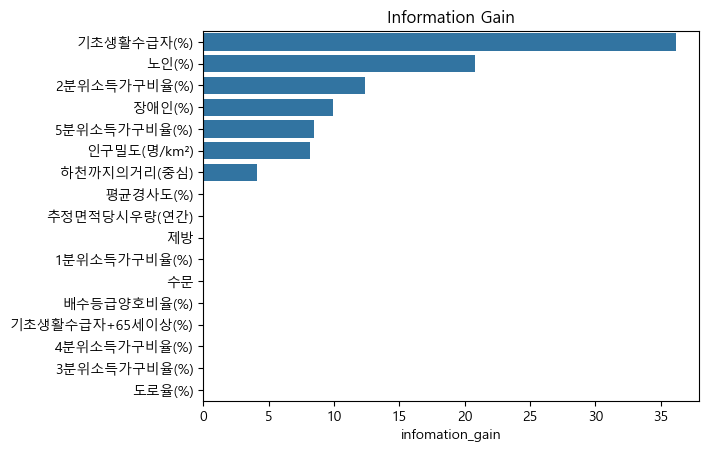

In [ ]:
plt.figure()
ax=sb.barplot(x=info_result["infomation_gain"],y=info_result["feature_name"])
box_col=info_result["feature_name"]
rename_col=[x.replace("_per","(%)") for x in box_col]
rename_col1=[x.replace("율(%)","율") for x in rename_col]
rename_col2=[x.replace("율","율(%)") for x in rename_col1]
ax.set_yticklabels(rename_col2)
plt.title("Information Gain")
plt.ylabel("")
plt.show()
plt.close()

In [ ]:
final_tree_model.feature_names_in_

array(['1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)',
       '5분위소득가구비율(%)', '기초생활수급자+65세이상_per', '기초생활수급자_per', '노인_per',
       '도로율', '배수등급양호비율', '수문', '인구밀도(명/km²)', '장애인_per', '제방',
       '추정면적당시우량(연간)', '평균경사도(%)', '하천까지의거리(중심)'], dtype=object)

In [ ]:
plt.figure()
box_col=final_tree_model.feature_names_in_
rename_col=[x.replace("_per","(%)") for x in box_col]
rename_col1=[x.replace("율(%)","율") for x in rename_col]
rename_col2=[x.replace("율","율(%)") for x in rename_col1]
sktree.plot_tree(final_tree_model,filled=True,feature_names=rename_col2,proportion=False)
plt.savefig("final_tree.png",dpi=1000,bbox_inches='tight')
plt.close()

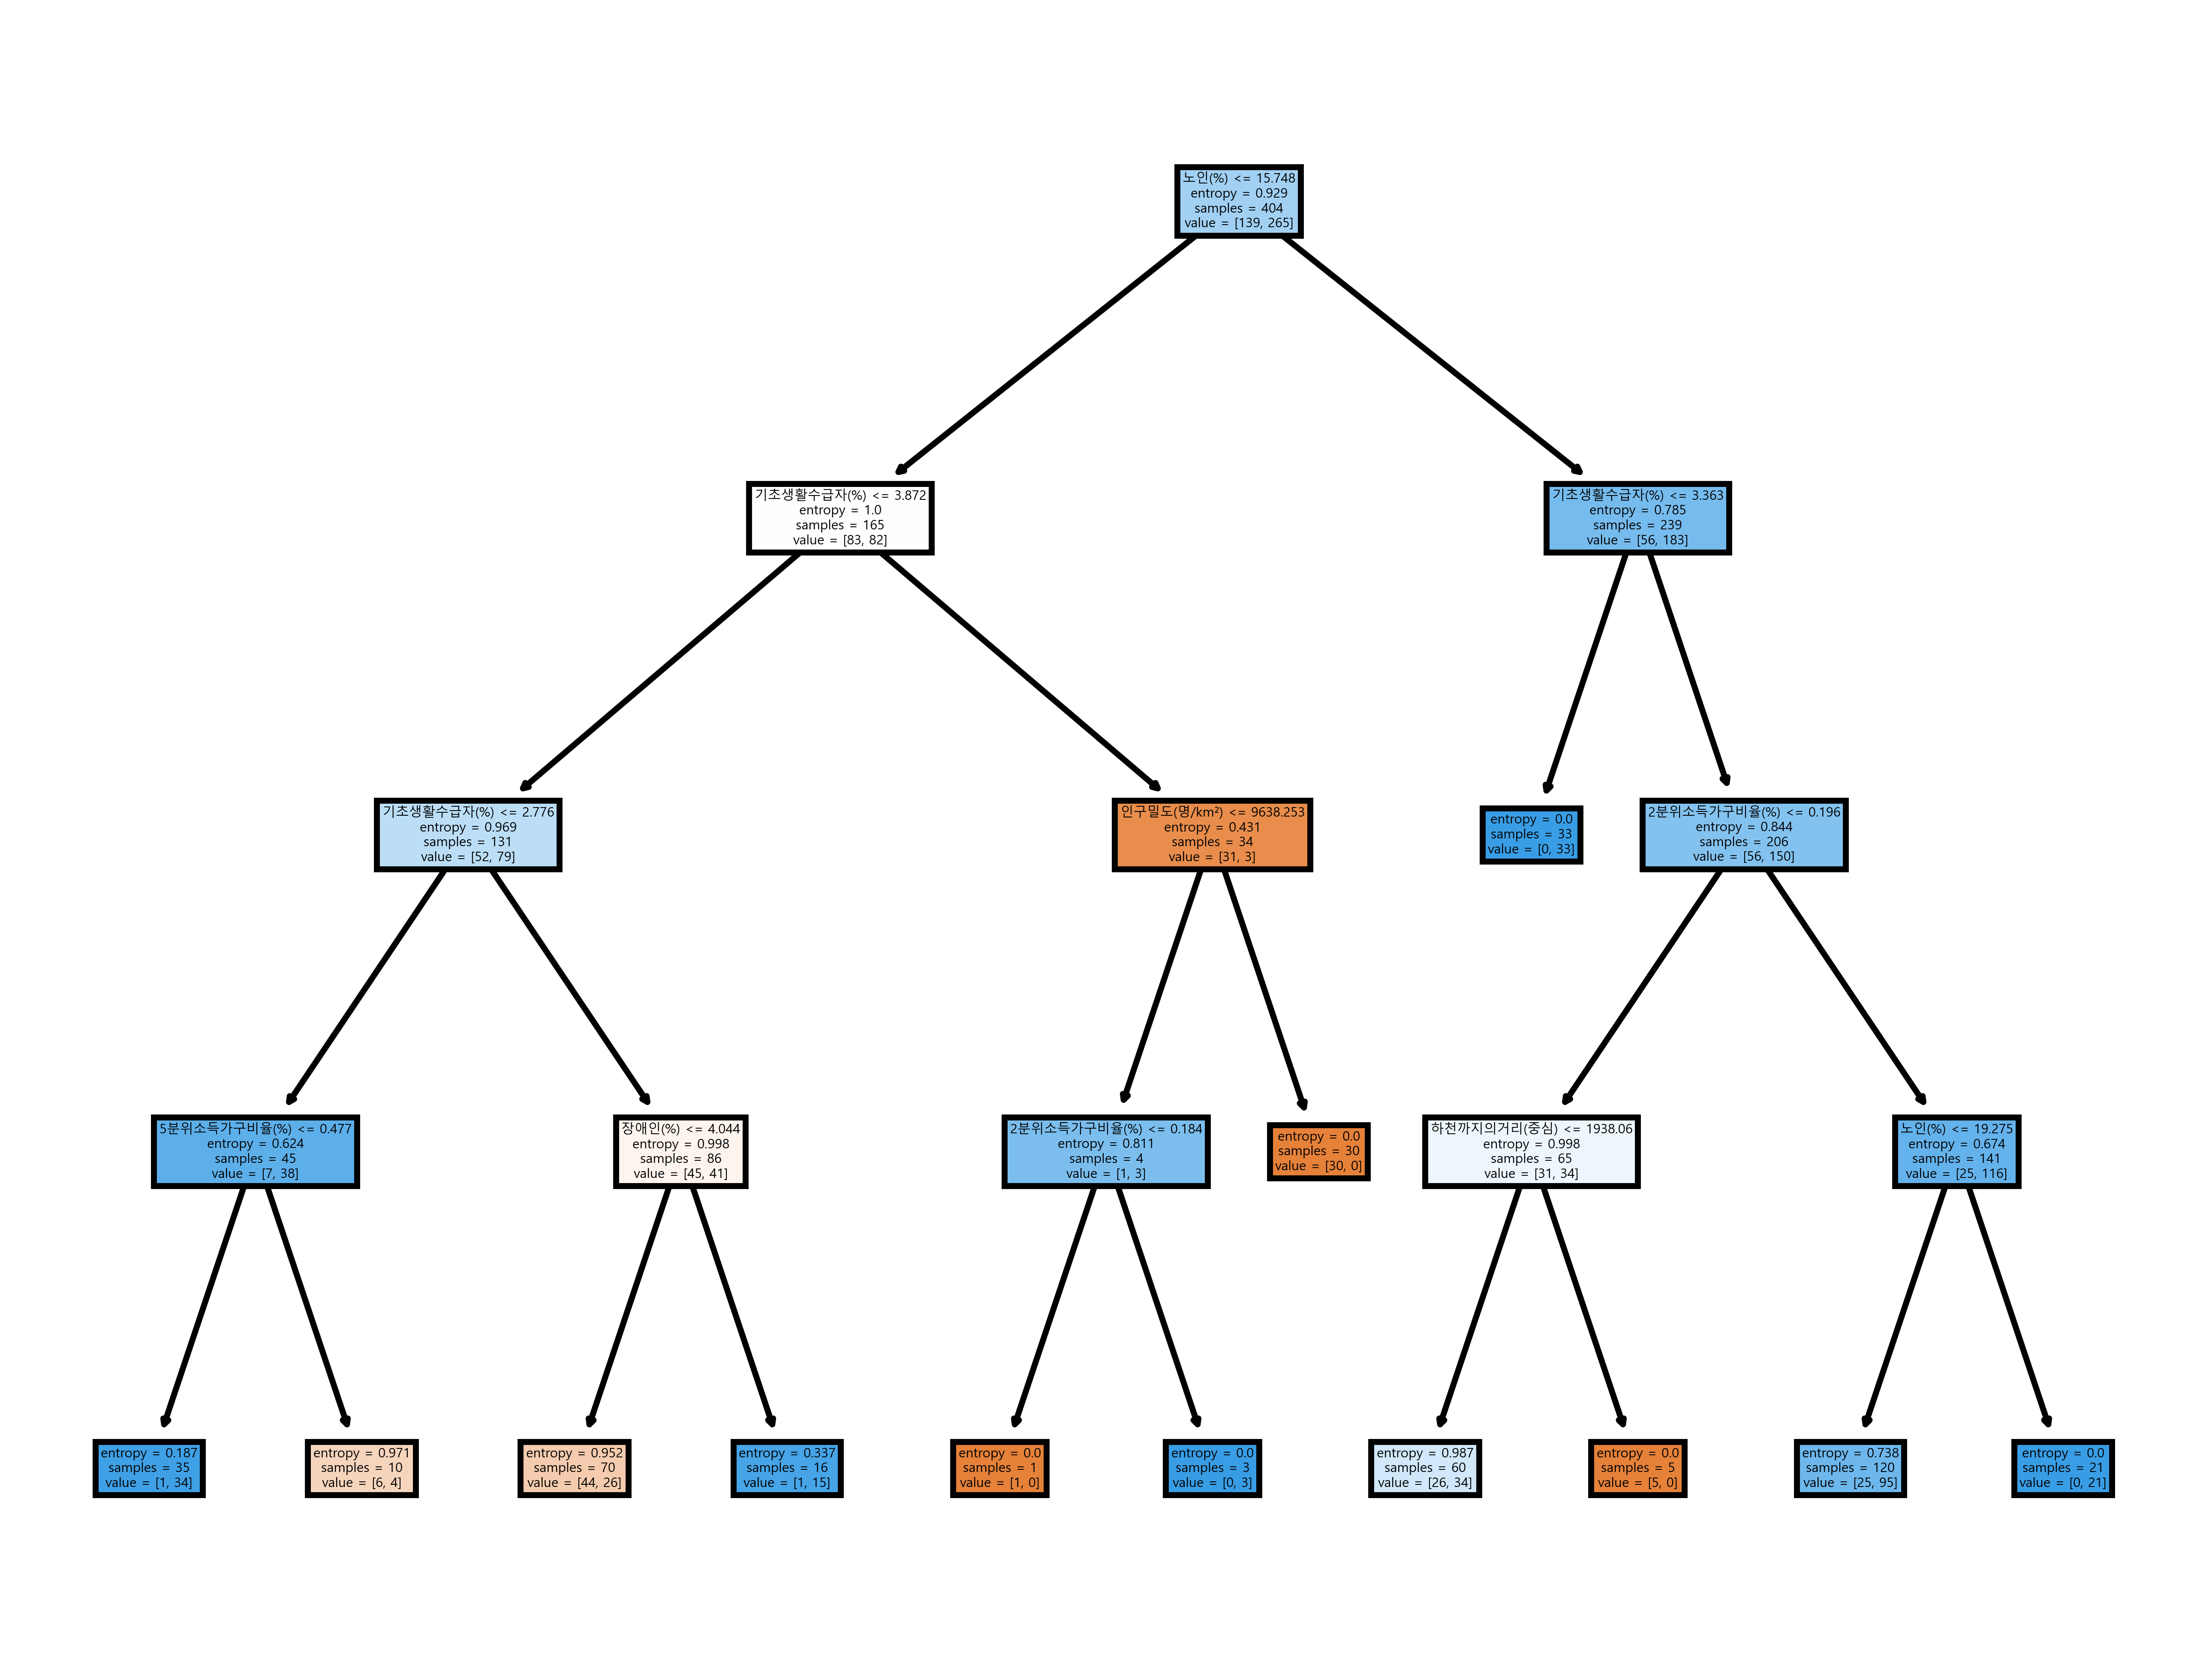

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree in .dot format
dot_data = export_graphviz(final_tree_model, out_file=None, 
                           feature_names=rename_col2,
                           filled=True,
                           proportion=False,
                           fontname="Malgun Gothic")

# Create a Graphviz object from the .dot data with the specified font
graph = graphviz.Source(dot_data, format="png", engine="dot", encoding="utf-8")

# Render the tree to a file (e.g., PNG)
output_file = "final_tree_graphviz.png"
graph.render(output_file)


'final_tree_graphviz.png.png'